In [1]:
DATA_PATH = '/root/Internship-Valeo/Project/data/COCO/'

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import os
from models.utils import *
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_images = os.listdir(DATA_PATH+'anntrain2014')
val_images = os.listdir(DATA_PATH+'annval2014')
mask_train_images = os.listdir(DATA_PATH+'anntrain2014')
mask_val_images = os.listdir(DATA_PATH+'annval2014')

In [4]:
image_shape = (240, 320,1)

In [5]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.001, # 1/65
            'descriptor_size': 256,
            'batch_size': 64,
            'epochs': 25,
            'learning_rate': 0.001,
            'kernel_reg': 0.,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 4,
            'top_k': 0
    }

In [29]:
def net():
    
    images_input = Input(shape = (240, 320,1), name = 'images_input')
    
    encoder = shared_encoder(model_config = model_config)
    encoder_output = encoder(images_input)
    
    detector = detector_head(model_config = model_config)
    detector_output = detector(encoder_output)
    
    model = keras.models.Model(inputs = images_input, outputs = detector_output)
    return model

In [7]:
model = net()

In [8]:
model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-no_aug')

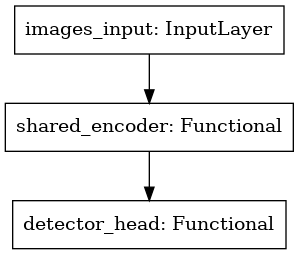

In [9]:
keras.utils.plot_model(model)

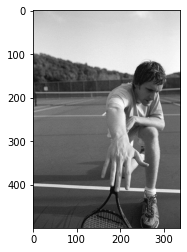

In [11]:
I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',train_images[0]),0)
plt.imshow(I, cmap = 'gray')

In [12]:
I.shape

(500, 339)

In [13]:
I = cv2.resize(I,(320, 240))
I = np.expand_dims(I, axis = 0)
I = np.expand_dims(I, axis = 3)

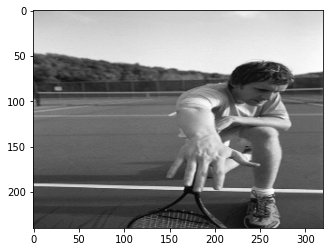

In [28]:
plt.imshow(I[0], cmap = 'gray')

In [24]:
result = model.predict(I)
result.shape

(1, 30, 40, 65)

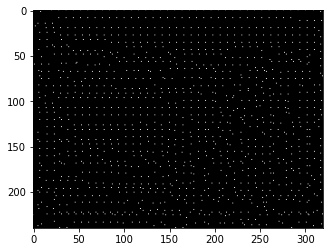

In [26]:
cfirst = model_config['data_format'] == 'channels_first'
cindex = 1 if cfirst else -1  # index of the channel
labels = tf.argmax(result, axis =cindex)
one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
# Strip the extra “no interest point” dustbin
one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
one_hot = tf.nn.depth_to_space(
              one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
one_hot = tf.squeeze(one_hot, axis=cindex)

plt.imshow((one_hot)[0], cmap = 'gray')

In [ ]:
for file_path in train_images:
    I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',file_path),0)
    I = cv2.resize(I,(320, 240))
    I = np.expand_dims(I, axis = 0)
    I = np.expand_dims(I, axis = 3)
    result = model.predict(I)
    
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    labels = tf.argmax(result, axis =cindex)
    one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
    # Strip the extra “no interest point” dustbin
    one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
    one_hot = tf.nn.depth_to_space(
              one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    one_hot = tf.squeeze(one_hot, axis=cindex)
    cv2.imwrite(os.path.join(DATA_PATH, 'pointstrain2014',file_path), np.array(one_hot[0]))

In [34]:
one_hot[0]

<tf.Tensor: shape=(240, 320), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>